In [13]:
import numpy as np
import scipy as sp
from skimage import io
from matplotlib import pyplot as plt
from skimage import transform
import scipy.ndimage as nd
from tqdm import tqdm
from time import time
import pickle
%matplotlib inline

from utils import shift, iou, normalize_alpha
from registration import (
    set_integration_intervals,
    laguerre_zeros_precompute, 
    image_fbt_precompute, 
    fbm_registration, apply_transform, apply_transform1, apply_transform2
)

In [14]:
def downsample_image(image, downsample_ratio):
    gaussian_sigma = downsample_ratio / 3.25
    smoothed_image = nd.gaussian_filter(image, gaussian_sigma)
    y_size, x_size = image.shape
    new_y_size, new_x_size = int(y_size / downsample_ratio), int(x_size / downsample_ratio)
    grid_x, grid_y = np.meshgrid(np.arange(new_x_size), np.arange(new_y_size))
    grid_x = grid_x * (x_size / new_x_size)
    grid_y = grid_y * (y_size / new_y_size)
    resampled_image = nd.map_coordinates(smoothed_image, [grid_y, grid_x], cval=0, order=3)
    return resampled_image


In [15]:
im1 = io.imread("im1.png")
# im1 = io.imread("lena_gray.png")
im1 = im1/255.

im1 = downsample_image(im1, 2)

In [16]:
from matrix_utils import *
import cv2

def shift(im, vec):
    mat_trans = get_translation_mat(*vec)
    return cv2.warpAffine(im, get_mat_2x3(mat_trans), 
                          (im.shape[1], im.shape[0]))
    
    
def rotate(im, angle, center=None):
    h, w = im.shape[:2]
    if center is None:
        center = np.array([w // 2, h // 2])
    mat_trans_minus_center = get_translation_mat(-center[0], -center[1])
    mat_rot = get_rotation_mat(angle, radians=True)
    mat_trans_center = get_translation_mat(*center)
    return cv2.warpAffine(im, get_mat_2x3(mat_trans_center @ mat_rot @ mat_trans_minus_center),
                          (im.shape[1], im.shape[0]))


def show_img_ovl(im1, im2):
    plt.figure()
    plt.imshow(np.stack([im1, im2, im2*0], -1))


def warp_img(im, warp_mat):
    return cv2.warpAffine(
        im, get_mat_2x3(warp_mat),
        (im.shape[1], im.shape[0]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


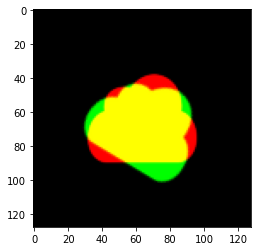

3.605551275463989 0.9827937232473289 -0.4417416551290868


In [17]:
init_ang = 31 * np.pi / 180.0
init_shift = (2, 3)
im2 = rotate(im1, init_ang)
im2 = shift(im2, init_shift)
io.imsave('im2.png', np.uint8(im2*255))

plt.imshow(np.stack([im1, im2, im2*0], -1))
plt.show()

gt_rho = np.sqrt(init_shift[0]**2 + init_shift[1]**2)
gt_phi = np.arctan2(init_shift[1], init_shift[0])
gt_psi = init_ang - gt_phi

print(gt_rho, gt_phi, gt_ksi)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


warp_mat_1
[[ 9.0400845e-01  4.2751458e-01  0.0000000e+00]
 [-4.2751458e-01  9.0400845e-01  1.9073486e-06]
 [ 0.0000000e+00  0.0000000e+00  1.0000000e+00]]
warp_mat_1
[[ 9.0400845e-01  4.2751458e-01  3.6055527e+00]
 [-4.2751458e-01  9.0400845e-01  1.9073486e-06]
 [ 0.0000000e+00  0.0000000e+00  1.0000000e+00]]
warp_mat_1
[[ 0.8571673 -0.5150381  2.       ]
 [ 0.5150381  0.8571673  3.       ]
 [ 0.         0.         1.       ]]


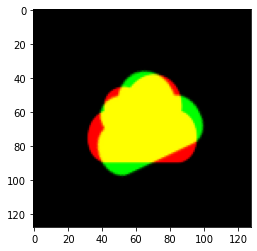

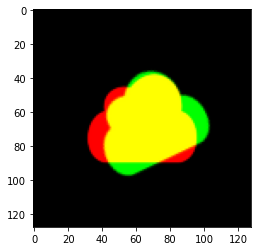

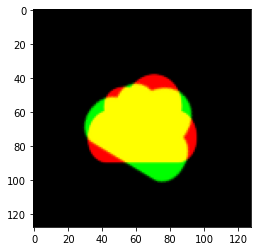

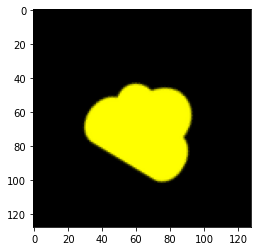

In [18]:
# direct computation of rot-trans-rot
# phi = 30 * np.pi / 180.0
# ksi = 40 * np.pi / 180.0
# rho = 10
phi = gt_phi
psi = gt_psi
rho = gt_rho

h, w = im1.shape[:2]
center = [w // 2, h // 2]

trans_mat_center = get_translation_mat(-center[0], -center[1])
trans_mat_rho = get_translation_mat(rho, 0)
rot_mat_phi = get_rotation_mat(phi, True)
rot_mat_psi = get_rotation_mat(psi, True)

# 
warp_mat_1 = mat_inv(trans_mat_center) @ rot_mat_psi @ trans_mat_center
im1_1 = warp_img(im1, warp_mat_1)
show_img_ovl(im1, im1_1)
print('warp_mat_1')
print(trans_mat_center @ warp_mat_1 @ mat_inv(trans_mat_center))

#
warp_mat_2 = mat_inv(trans_mat_center) @ trans_mat_rho @ rot_mat_psi @ trans_mat_center
im1_2 = warp_img(im1, warp_mat_2)
show_img_ovl(im1, im1_2)
print('warp_mat_1')
print(trans_mat_center @ warp_mat_2 @ mat_inv(trans_mat_center))

#
warp_mat_3 = mat_inv(trans_mat_center) @ rot_mat_phi @ trans_mat_rho @ rot_mat_psi @ trans_mat_center
im1_3 = warp_img(im1, warp_mat_3)
show_img_ovl(im1, im1_3)
print('warp_mat_1')
print(trans_mat_center @ warp_mat_3 @ mat_inv(trans_mat_center))


# init_ang = 
im1_direct = rotate(im1, phi + psi)
im1_direct = shift(im1_direct, (rho*np.cos(phi), rho*np.sin(phi)))

show_img_ovl(im1_3, im1_direct)

In [19]:
# bandwidth = 128
pixel_sampling = 0.5
pho_max = 20.
# lag_func_num=60
# lag_scale=3
image_radius = int(im1.shape[0] / 2)

In [20]:
def print_net_params(net):
    print(net[0], net[-1], net.shape, net[1]-net[0])

m1_net, h1_net, mm_net, theta_net, u_net, x_net, omega_net, ksi_net, eta_net, eps, b, bandwidth = \
            set_integration_intervals(image_radius, pixel_sampling, pho_max)
# alphas = []
# for it_m1 in tqdm(range(len(Im1))):
#     m1 = Im1[it_m1]
#     for it_h1 in range(len(Ih1)):
#         h1 = Ih1[it_h1]
#         for it_mm in range(len(Imm)):
#             mm = Imm[it_mm]
#             if abs(m1 + h1 + mm) in alphas:
#                 continue
#             alphas.append(abs(m1 + h1 + mm))

# image_radius = 2 * bandwidth * pixel_sampling / np.pi
# print(image_radius)
print_net_params(theta_net)
print_net_params(u_net)
print_net_params(x_net)

print_net_params(omega_net)
print_net_params(ksi_net)
print_net_params(eta_net)

64
s_ang = 402.1238596594935
s_rad = 128.0
bandwidth = 201.06192982974676
0.0 6.283185307179586 (402,) 0.015668791289724655
0.0 64.0 (128,) 0.5039370078740157
0.0 3.141592653589793 (128,) 0.024736950028266088
-3.141592653589793 3.141592653589793 (201,) 0.031415926535897754
-3.141592653589793 3.141592653589793 (125,) 0.05067084925144849
-3.141592653589793 3.141592653589793 (40,) 0.1611073155687075


In [21]:
mask1 = im1# > 0
mask2 = im2# > 0

In [22]:
# from skimage.measure import label, regionprops
# # mask1 = im1 > 0
# props = regionprops(label(mask1))
# c1y, c1x = props[0].centroid
# center = c1x, c1y
# print(center)

In [23]:
start = time()
# reg1 = fbm_registration(im1, im2, image_radius=image_radius, p_s=pixel_sampling, com_offset=com_offset,
#                        method='fbm', masks=[mask1>0, mask2>0], shift_by_mask=False)
reg1 = fbm_registration(im1, im2, image_radius=image_radius, p_s=pixel_sampling, com_offset=pho_max,
                       method='fbm', masks=[], shift_by_mask=False)
end = time()


64
s_ang = 402.1238596594935
s_rad = 128.0
bandwidth = 201.06192982974676


In [ ]:
print(reg1)

file = open('reg_results.json', 'wb')
pickle.dump(reg1, file)
file.close()



In [ ]:
file = open('reg_results.json', 'rb')
reg2 = pickle.load(file)
file.close()
print(reg2)

# im2_reg, im2_reg_rot_only, t, angle = apply_transform1(im2, reg1)

# print("t", t)
# print("angle", angle * 180 / np.pi)

im2_reg = apply_transform(im2, reg2)

print('IoU:', iou(im1, im2_reg))
print('Time:', end - start, 'secs')

In [ ]:



ksi = reg1['ksi']
eta_prime = reg1['eta']
omega_prime = reg1['omega']
b = reg1['com_offset'] / 2

eta = eta_prime - ksi
omega = omega_prime - eta_prime

# eta = eta_prime
# omega = omega_prime

# ksi = normalize_alpha(ksi)
# eta = normalize_alpha(eta)
# omega = normalize_alpha(omega)

h, w = im1.shape[:2]
center = [w // 2, h // 2]

trans_mat_center = get_translation_mat(-center[0], -center[1])
trans_mat_b = get_translation_mat(b, 0)
rot_mat_ksi = get_rotation_mat(ksi, True)
rot_mat_eta = get_rotation_mat(eta, True)
rot_mat_omega = get_rotation_mat(omega, True)

# 
warp_mat_1 = mat_inv(trans_mat_center) @ rot_mat_ksi @ trans_mat_center
im1_1 = warp_img(im1, mat_inv(warp_mat_1))
show_img_ovl(im1, im1_1)
print('warp_mat_1')
print(trans_mat_center @ warp_mat_1 @ mat_inv(trans_mat_center))

#
warp_mat_2 = mat_inv(trans_mat_center) @ trans_mat_b @ rot_mat_ksi @ trans_mat_center
im1_2 = warp_img(im1, mat_inv(warp_mat_2))
show_img_ovl(im1, im1_2)
print('warp_mat_2')
print(trans_mat_center @ warp_mat_2 @ mat_inv(trans_mat_center))

#
warp_mat_3 = mat_inv(trans_mat_center) @ rot_mat_eta @ trans_mat_b @ rot_mat_ksi @ trans_mat_center
im1_3 = warp_img(im1, mat_inv(warp_mat_3))
show_img_ovl(im1, im1_3)
print('warp_mat_3')
print(trans_mat_center @ warp_mat_3 @ mat_inv(trans_mat_center))

#
warp_mat_4 = mat_inv(trans_mat_center) @ trans_mat_b @ rot_mat_eta @ trans_mat_b @ rot_mat_ksi @ trans_mat_center
im1_4 = warp_img(im1, mat_inv(warp_mat_4))
show_img_ovl(im1, im1_4)
print('warp_mat_4')
print(trans_mat_center @ warp_mat_4 @ mat_inv(trans_mat_center))

#
warp_mat_5 = mat_inv(trans_mat_center) @ rot_mat_omega @ trans_mat_b @ rot_mat_eta @ trans_mat_b @ rot_mat_ksi @ trans_mat_center
im1_5 = warp_img(im1, mat_inv(warp_mat_5))
show_img_ovl(im1, im1_5)
print('warp_mat_5')
print(trans_mat_center @ warp_mat_5 @ mat_inv(trans_mat_center))


In [ ]:
plt.figure()
plt.imshow(np.stack([im1, im2, im2*0], -1))

# plt.figure()
# plt.imshow(np.stack([im1, im2_reg_rot_only, im2*0], -1))
# plt.xlim(25, 100)
# plt.ylim(100, 25)

reflection_mat = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]]).astype(np.float32)
h, w = im2.shape[:2]
center = [w // 2, h // 2]
mat_trans_center = get_translation_mat(*center)

mat_all = mat_trans_center @ reflection_mat @ mat_inv(mat_trans_center)

im3_reg = cv2.warpAffine(
        im2_reg, get_mat_2x3(mat_all),
        (im2_reg.shape[1], im2_reg.shape[0]))


plt.figure()
plt.imshow(np.stack([im1, im3_reg, im2*0], -1))
# plt.xlim(25, 100)
# plt.ylim(100, 25)


In [ ]:
reg1

In [ ]:
reg1

<div>
<img src="illustration.jpeg" width="500"/>
</div>

In [ ]:
from utils import normalize_alpha


In [ ]:
transform_dict = reg1
h, w = im2.shape[:2]
# if center is None:
center = np.array([w // 2, h // 2])
image = im2.copy()
ksi = transform_dict['ksi']
eta_prime = transform_dict['eta']
omega_prime = transform_dict['omega']
eta = eta_prime - ksi
omega = omega_prime - eta_prime
eps = transform_dict['eps']
pho_max = transform_dict['com_offset']

x = pho_max * np.cos(ksi) + pho_max * np.cos(ksi + eta + eps)
y = pho_max * np.sin(ksi) + pho_max * np.sin(ksi + eta + eps)
rho = (2*pho_max**2 + 2*pho_max**2 * np.cos(ksi + eta + eps))**0.5
cos_alpha = 3/rho
print('rho', rho, cos_alpha, np.degrees(np.arccos(cos_alpha)), rho*np.sin(np.arccos(cos_alpha)))
# x, y = 4., 3.
print(x, y)
alpha = omega_prime + eps

print(np.degrees(alpha), np.degrees(normalize_alpha(alpha)))

mat_trans = get_translation_mat(-x, -y)

im_shifted = cv2.warpAffine(
    im2, get_mat_2x3(mat_trans),
    (im2.shape[1], im2.shape[0])
)
plt.figure()
plt.imshow(np.stack([im1, im_shifted, im2*0], -1))

mat_trans_minus_center = get_translation_mat(-center[0], -center[1])
mat_rot = get_rotation_mat(-normalize_alpha(alpha), radians=True)
mat_trans_center = get_translation_mat(center[0], center[1])
im_rotated = cv2.warpAffine(
    im_shifted, get_mat_2x3(mat_trans_center @ mat_rot @ mat_trans_minus_center),
    (im2.shape[1], im2.shape[0])
)
plt.figure()
plt.imshow(np.stack([im1, im_rotated, im2*0], -1))
print('IoU:', iou(im1, im_rotated))

In [ ]:
transform_dict = reg1
h, w = im2.shape[:2]
# if center is None:
center = np.array([w // 2, h // 2])
image = im2.copy()
ksi = transform_dict['ksi']
eta_prime = transform_dict['eta']
omega_prime = transform_dict['omega']
eta = eta_prime - ksi
omega = omega_prime - eta_prime
eps = transform_dict['eps']
b = transform_dict['com_offset']
print(np.degrees(ksi), np.degrees(eta), np.degrees(omega), np.degrees(eps))

print(np.degrees(omega_prime + eps))
im_f1 = rotate(im2, np.degrees(omega))
plt.figure()
plt.imshow(np.stack([im1, im_f1, im2*0], -1))
im_f2 = shift(im_f1, (b, 0))
plt.figure()
plt.imshow(np.stack([im1, im_f2, im2*0], -1))
im_f3 = rotate(im_f2, np.degrees(eta))
plt.figure()
plt.imshow(np.stack([im1, im_f3, im2*0], -1))
im_f4 = shift(im_f3, (b, 0))
plt.figure()
plt.imshow(np.stack([im1, im_f4, im2*0], -1))
im_f5 = rotate(im_f4, np.degrees(ksi))
plt.figure()
plt.imshow(np.stack([im1, im_f5, im2*0], -1))
im_f6 = im_f5[::-1, ::-1]
plt.figure()
plt.imshow(np.stack([im1, im_f6, im2*0], -1))
plt.title(f'iou: {iou(im1, im_f6)}')